In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [27]:
#44009 and 44065 were the two buoys lying right on the trajectory of the hurricane 
#so we decided to use them to analyse the data further
df_b7_init = pd.read_csv('/Users/shreyabanerjee/DA_proj/clean_csvs/44009_clean.csv')
df_b8_init = pd.read_csv('/Users/shreyabanerjee/DA_proj/clean_csvs/44065_clean.csv')

#adding the two dataframes
df=pd.concat([df_b7_init,df_b8_init],axis=0)

Text(0.5, 0, 'Pressure(in hPA)')

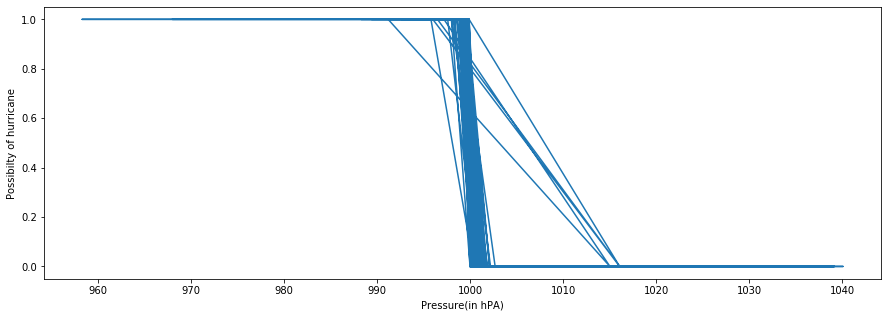

In [28]:
#the possibility coulmn has value 1 if the pressure is less than 1000, which seems to be the threshold value for
#indication of hurricane

x=df['pressure']
y1=df['possibility']
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.plot(x, y1)
ax1.set_ylabel('Possibilty of hurricane')
ax1.set_xlabel('Pressure(in hPA)')

In [29]:
y1.value_counts()

0.0    16184
1.0      467
Name: possibility, dtype: int64

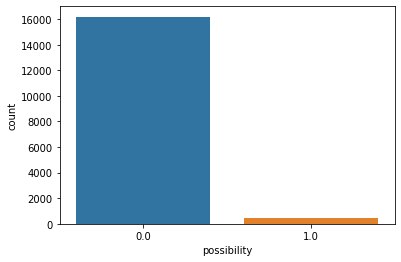

In [30]:
sns.countplot(x='possibility',data=df)
plt.show()

In [31]:
count_no_sub = len(y1[y1==0])
count_sub = len(y1[y1==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("Percentage of instances with no occurence of hurricane ", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("Percentage of instances where hurricane actually occured", pct_of_sub*100)

Percentage of instances with no occurence of hurricane  97.19536364182332
Percentage of instances where hurricane actually occured 2.804636358176686


INFERENCE:
There is a gross imbalance of data. There are very small number of intances of actual interest.

OBSERVATIONS SO FAR:
Pressure,windspeed and waveheight are the features most affected by the occurence of a hurricane.
There are a very few instances of interest.

Let us try to upsample the no-hurricane data using the SMOTE algorithm(Synthetic Minority Oversampling Technique).
A few facts about SMOTE:
1)Works by creating synthetic samples from the minor class (no-subscription) instead of creating copies.
2)Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

We will over-sample only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

In [32]:
keep_col = ['day','month','waveperiod','waveheight','WindDir','windspeed','pressure']

X = df[keep_col]
y = df['possibility']

os = SMOTE(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['possibility'])

# we can Check the numbers of our data
print("Length of oversampled data is ",len(os_data_X))
print("Number of no hurricane (possibility=0) readings in oversampled data",len(os_data_y[os_data_y['possibility']==0]))
print("Number of hurricane occurence readings",len(os_data_y[os_data_y['possibility']==1]))
print("Proportion of no hurricane data in oversampled data is ",len(os_data_y[os_data_y['possibility']==0])/len(os_data_X))
print("Proportion of hurricane data in oversampled data is ",len(os_data_y[os_data_y['possibility']==1])/len(os_data_X))

Length of oversampled data is  22656
Number of no hurricane (possibility=0) readings in oversampled data 11328
Number of hurricane occurence readings 11328
Proportion of no hurricane data in oversampled data is  0.5
Proportion of hurricane data in oversampled data is  0.5


Now, the question arises , which features to take as predictor variables ?
Irrelevant or partially relevant features can negatively impact model performance.
The main problem is that factors like day, month, hour and minute obviously do not affect the occurence of a hurricane.
Features like pressure, windspeed and waveheight might change drastically in such events. 
Our previous visualisations and conclusions support this fact.
Let's just try building a model using these features.

In [33]:
keep_col2 = ['windspeed','pressure']#'waveheight']
logit = os_data_X[keep_col2]
y1=os_data_y['possibility']

In [34]:
X_train, x_test, y_train, y_test = train_test_split(logit,y1,test_size=0.3, random_state=0)
logreg = LogisticRegression()
result=logreg.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [35]:
y_pred = logreg.predict(x_test)

In [36]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.82


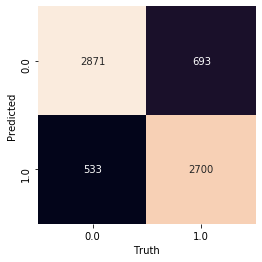

In [37]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_pred, y_test)
names = np.unique(y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,xticklabels=names, yticklabels=names)
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

In [38]:
print(classification_report(y_test, y_pred ))

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.82      3404
         1.0       0.84      0.80      0.81      3393

    accuracy                           0.82      6797
   macro avg       0.82      0.82      0.82      6797
weighted avg       0.82      0.82      0.82      6797



In [39]:
#trying to test the trained model on one of the buoy data ( imbalanced data)
x1=df_b8_init[keep_col2]
y1=df_b8_init['possibility']
y_pred8 = logreg.predict(x1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x1, y1)))


Accuracy of logistic regression classifier on test set: 0.83


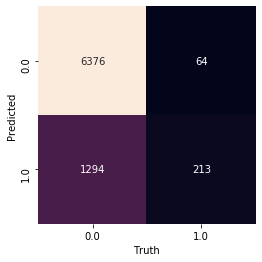

In [40]:
mat = confusion_matrix(y_pred8, y1)
names = np.unique(y_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,xticklabels=names, yticklabels=names)
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.show()

In [18]:
print(classification_report(y1, y_pred8 ))

              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90      7670
         1.0       0.14      0.77      0.24       277

    accuracy                           0.83      7947
   macro avg       0.57      0.80      0.57      7947
weighted avg       0.96      0.83      0.88      7947



In [41]:
predicted_dataframe=pd.read_csv('/Users/shreyabanerjee/DA_PROJ/MODEL/ANOMALY DETECTION/predicted.csv')
keep_col3=['predicted_pressure','predicted_windspeed']
x=predicted_dataframe[keep_col3]
y_pred = logreg.predict(x)
for i in range(len(x)):
    print("%s,%d",x.iloc[i],y_pred[i])

%s,%d predicted_pressure     1005.900000
predicted_windspeed       7.759032
Name: 0, dtype: float64 1.0
%s,%d predicted_pressure     1005.60000
predicted_windspeed       7.73714
Name: 1, dtype: float64 1.0
%s,%d predicted_pressure     1004.700000
predicted_windspeed       8.418898
Name: 2, dtype: float64 1.0
%s,%d predicted_pressure     1003.500000
predicted_windspeed       9.678843
Name: 3, dtype: float64 1.0
%s,%d predicted_pressure     1002.500000
predicted_windspeed       9.479898
Name: 4, dtype: float64 1.0
%s,%d predicted_pressure     1000.900000
predicted_windspeed      10.335051
Name: 5, dtype: float64 1.0
%s,%d predicted_pressure     999.300000
predicted_windspeed     10.746589
Name: 6, dtype: float64 1.0
%s,%d predicted_pressure     997.200000
predicted_windspeed     11.432888
Name: 7, dtype: float64 1.0
%s,%d predicted_pressure     1015.041380
predicted_windspeed      12.797965
Name: 8, dtype: float64 1.0
%s,%d predicted_pressure     991.200000
predicted_windspeed     13.373

INTERPRETING THESE RESULTS

ACCURACY
In our dataset, the positive class — occurence of hurricane — is greatly outnumbered by the negative class. Accuracy is not a good measure for assessing model performance.

Looking at the confusion matrix , it can be clearly said that:-
1) The recall for 1.0 is 0.77 i.e, out of all the positive classes (occurence of hurricane), we predicted 0.77 correctly. 
2) The precision for 1.0 is 0.15 i.e, out of all the positive classes we have predicted correctly, 0.15 are actually positive.( i.e, a lot of false positives)

Most of the hurricane occurences are predicted correctly, but out of all the positive predictions, a lot of them are actually negative.


DRAWBACKS : The chances of raising false alarms are pretty high.

ANALYSING SMOTE

ADVANTAGES
Mitigates the problem of overfitting caused by random oversampling as synthetic examples are generated rather than replication of instances
No loss of useful information

DISADVANTAGES
While generating synthetic examples SMOTE does not take into consideration neighboring examples from other classes. This can result in increase in overlapping of classes and can introduce additional noise
SMOTE is not very effective for high dimensional data